In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 day 6 hours 11 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_per_christian_43xdwe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

In [4]:
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')


In [5]:
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')



In [6]:
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')


# Things to Explore

1. Location B and C yields almost exact results on first model -> Are the two datasets very similar?
2. y_train_c has a lot of NaN values compared to A and B

# Data Preprocessing 
(Move this to seperate notebook)

**1. Merge observed and estimated training data**

**2. Handle NaN values**
- Look through all features and handle seperately, according to nature of the feature

**3.  Aggregate weather data from every 15 minute to hourly.**
- Average, sum, max/min, first/last etc. depending on the nature of the metric.
- Ensure the timestamps between weather data and power production align.

**4. Handle missing solar power measurements from 2022-10-21 01:00 - 2022-10-28 21:00**

### 1. Merge observed and estimated training data**

In [7]:
def merge_training_data(location):
    if location.lower() == 'a':
        X_train = pd.concat([X_train_observed_a,X_train_estimated_a])
    elif location.lower() == 'b':
        X_train = pd.concat([X_train_observed_b,X_train_estimated_b])
    elif location.lower() == 'c':
        X_train = pd.concat([X_train_observed_c,X_train_estimated_c])
    else:
        raise ValueError(f"Invalid location: {location}")
    return X_train

In [8]:
#Consider removing date_calc column
X_train_a = merge_training_data('a')
X_train_b = merge_training_data('b')
X_train_c = merge_training_data('c')

### 2. Handle NaN values

In [9]:
##

### 3. Aggregate weather data from every 15 minute to hourly averages

In [10]:
agg_dict1 = {'clear_sky_energy_1h:J': 'sum',
 'diffuse_rad_1h:J': 'sum',
 'direct_rad_1h:J': 'sum',
 'precip_5min:mm': 'sum',
 'fresh_snow_1h:cm': 'sum',
 'fresh_snow_3h:cm': 'sum',
 'snow_melt_10min:mm': 'sum',
 'rain_water:kgm2': 'sum',
 'super_cooled_liquid_water:kgm2': 'sum',
 'wind_speed_10m:ms': 'max',
 'dew_or_rime:idx': 'sum',
 'is_day:idx': 'sum',
 'is_in_shadow:idx': 'sum',
 'snow_drift:idx': 'sum',
 'precip_type_5min:idx': 'sum',
 'absolute_humidity_2m:gm3': 'mean',
 'air_density_2m:kgm3': 'mean',
 'ceiling_height_agl:m': 'mean',
 'clear_sky_rad:W': 'mean',
 'cloud_base_agl:m': 'mean',
 'dew_point_2m:K': 'mean',
 'diffuse_rad:W': 'mean',
 'direct_rad:W': 'mean',
 'effective_cloud_cover:p': 'mean',
 'elevation:m': 'mean',
 'msl_pressure:hPa': 'mean',
 'pressure_100m:hPa': 'mean',
 'pressure_50m:hPa': 'mean',
 'prob_rime:p': 'mean',
 'relative_humidity_1000hPa:p': 'mean',
 'sfc_pressure:hPa': 'mean',
 'snow_density:kgm3': 'mean',
 'snow_depth:cm': 'mean',
 'sun_azimuth:d': 'mean',
 'sun_elevation:d': 'mean',
 't_1000hPa:K': 'mean',
 'total_cloud_cover:p': 'mean',
 'visibility:m': 'mean',
 'wind_speed_u_10m:ms': 'mean',
 'wind_speed_v_10m:ms': 'mean',
 'wind_speed_w_1000hPa:ms': 'mean',
 'fresh_snow_12h:cm': 'last',
 'snow_water:kgm2': 'mean',
 'fresh_snow_24h:cm':'last',
 'fresh_snow_6h:cm':'last'}

agg_dict2 = {
 'absolute_humidity_2m:gm3': 'mean',
 'air_density_2m:kgm3': 'mean',
 'ceiling_height_agl:m': 'mean',
 'clear_sky_energy_1h:J': 'sum',
 'clear_sky_rad:W': 'mean',
 'cloud_base_agl:m': 'mean',
 'dew_or_rime:idx': 'mode',
 'dew_point_2m:K': 'mean',
 'diffuse_rad:W': 'mean',
 'diffuse_rad_1h:J': 'sum',
 'direct_rad:W': 'mean',
 'direct_rad_1h:J': 'sum',
 'effective_cloud_cover:p': 'mean',
 'elevation:m': 'mean',
 'fresh_snow_12h:cm': 'sum',
 'fresh_snow_1h:cm': 'sum',
 'fresh_snow_24h:cm': 'sum',
 'fresh_snow_3h:cm': 'sum',
 'fresh_snow_6h:cm': 'sum',
 'is_day:idx': 'max',
 'is_in_shadow:idx': 'max',
 'msl_pressure:hPa': 'mean',
 'precip_5min:mm': 'sum',
 'precip_type_5min:idx': 'mode',
 'pressure_100m:hPa': 'mean',
 'pressure_50m:hPa': 'mean',
 'prob_rime:p': 'mean',
 'rain_water:kgm2': 'sum',
 'relative_humidity_1000hPa:p': 'mean',
 'sfc_pressure:hPa': 'mean',
 'snow_density:kgm3': 'mean',
 'snow_depth:cm': 'mean',
 'snow_drift:idx': 'mode',
 'snow_melt_10min:mm': 'sum',
 'snow_water:kgm2': 'sum',
 'sun_azimuth:d': 'mean',
 'sun_elevation:d': 'mean',
 'super_cooled_liquid_water:kgm2': 'max',
 't_1000hPa:K': 'mean',
 'total_cloud_cover:p': 'mean',
 'visibility:m': 'mean',
 'wind_speed_10m:ms': 'mean',
 'wind_speed_u_10m:ms': 'mean',
 'wind_speed_v_10m:ms': 'mean',
 'wind_speed_w_1000hPa:ms': 'mean'
}


remaining = list(set(X_train_b.columns) - set(agg_dict2.keys()))


In [11]:
def transform_to_hourly(X,agg_dict, mean = False):
    if mean:
        return X.resample('H', on = 'date_forecast').mean()
    return X.resample('H', on = 'date_forecast').agg(agg_dict)

#Remove data in X_train that has timestamp that does not exist in train_a/b/c 
#e.g missing solar power measurements from 2022-10-21 01:00 - 2022-10-28 21:00
def pre_process(X_train,X_test, y_train):
    X_train_hourly = transform_to_hourly(X_train,agg_dict1)
    x_test = transform_to_hourly(X_test, agg_dict1)
    x_train = X_train_hourly.copy()[X_train_hourly.index.isin(y_train['time'])]
    y_train = y_train[y_train['time'].isin(x_train.index)]
    return x_train,x_test,y_train

In [12]:
#Pre-Process dataset A 
X_train_a, X_test_a, y_train_a = pre_process(X_train_a,X_test_estimated_a,train_a)
X_train_b, X_test_b, y_train_b = pre_process(X_train_b,X_test_estimated_b,train_b)
X_train_c, X_test_c, y_train_c = pre_process(X_train_c,X_test_estimated_c,train_c)

### 

# Exploratory Data Analysis

## Analysis of Target variable 
1. Handle constant measurments over longer periods of time. Likely caused by sensor malfunction, data logging issues, or other external factors.
2. Handle longer periods of missing data:
    - Interpolate 
    - Copy from previous year
    - Copy solar production at missing time from another location

In [26]:
# Time-Series plot
def solar_prod_plot(y_train, years_per_plot = 5):
    df = y_train.copy()
    # Get the unique years
    unique_years = df['time'].dt.year.unique()

    # Loop over the years in chunks
    for i in range(0, len(unique_years), years_per_plot):
        subset_years = unique_years[i:i+years_per_plot]

        # Filter the dataframe for the current chunk of years
        subset_df = df[df['time'].dt.year.isin(subset_years)]

        plt.figure(figsize=(15, 6))
        plt.plot(subset_df['time'], subset_df['pv_measurement'])

        title = f"Solar Power Production for {subset_years[0]}"
        if len(subset_years) > 1:
            title += f" to {subset_years[-1]}"

        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("PV Measurement")
        plt.show()

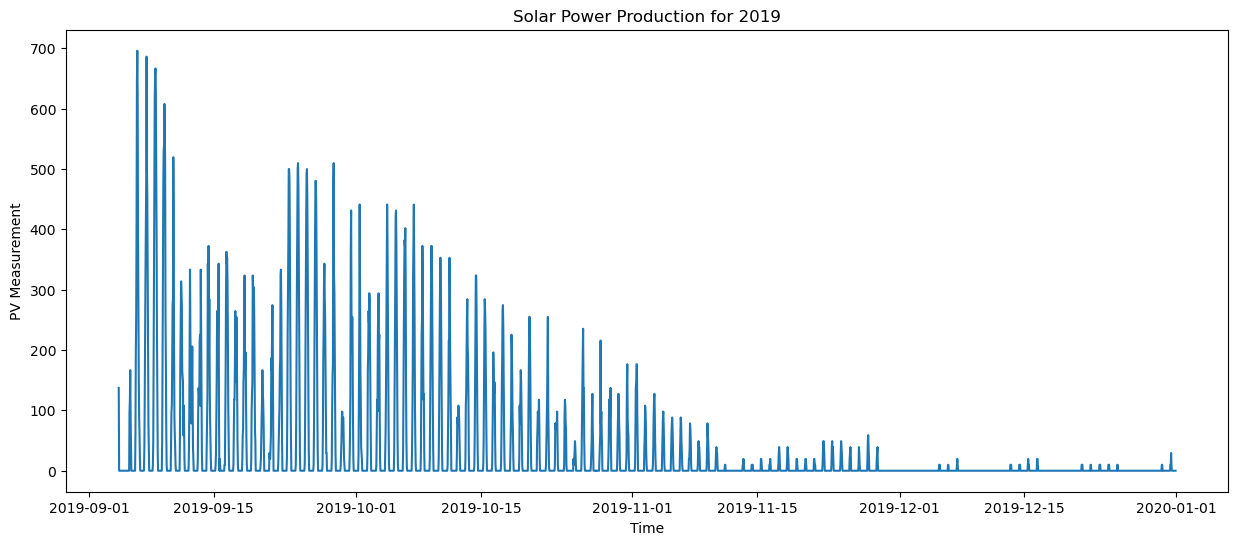

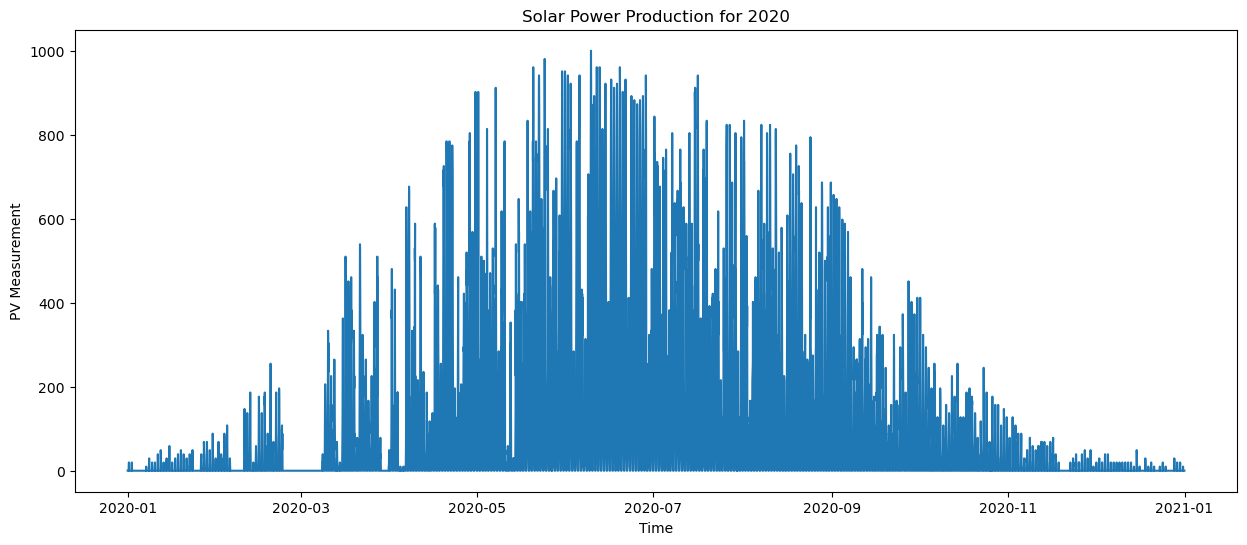

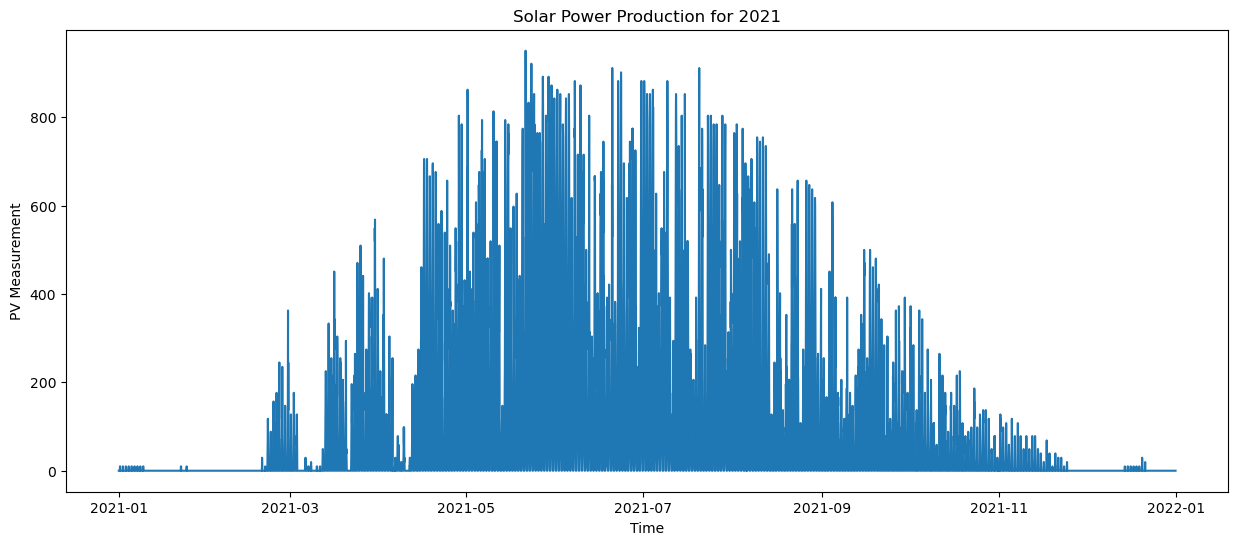

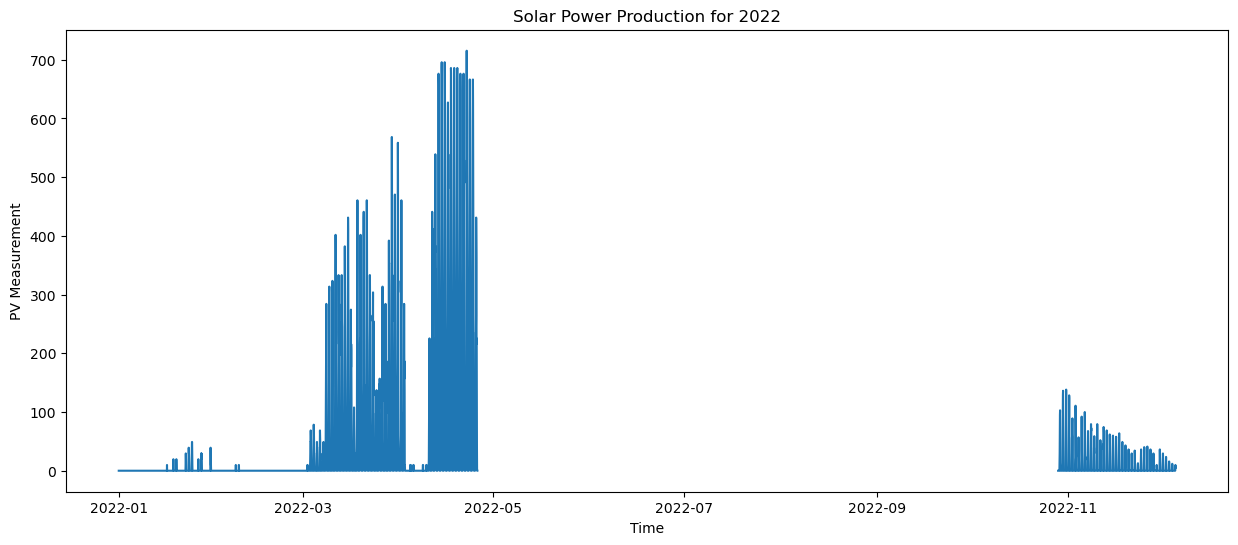

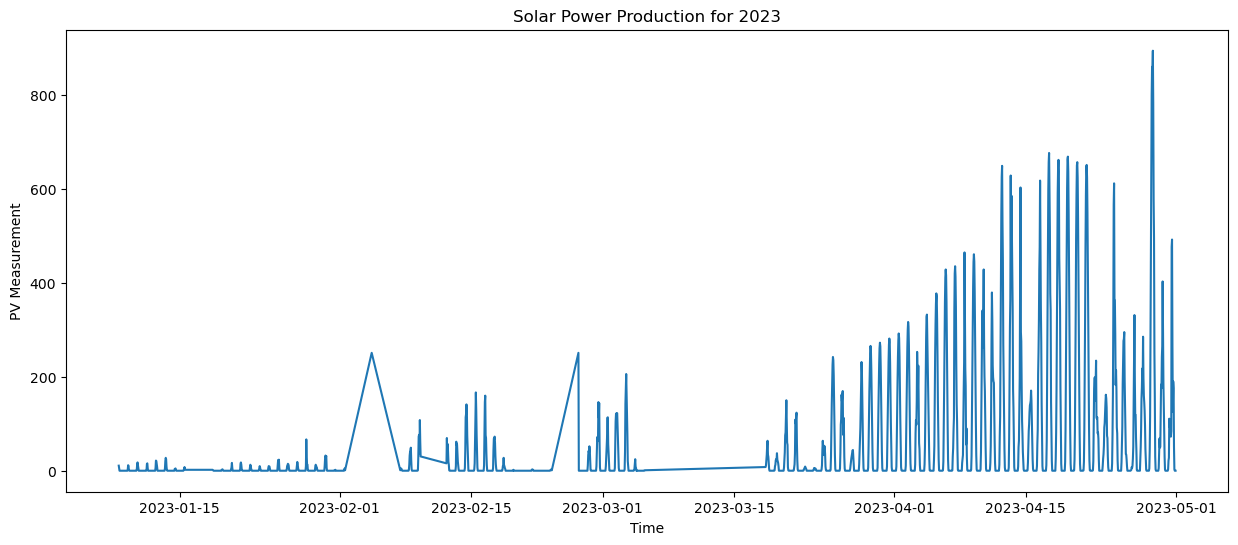

In [27]:
solar_prod_plot(y_train_c,1)

In [169]:
def nan_vals(y_train):
    return y_train[y_train['pv_measurement'].isna()]

nan_vals(y_train_c)

,time,pv_measurement
1,2019-01-01 00:00:00,NaN
2,2019-01-01 01:00:00,NaN
3,2019-01-01 02:00:00,NaN
4,2019-01-01 03:00:00,NaN
5,2019-01-01 04:00:00,NaN
...,...,...
29196,2022-05-01 17:00:00,NaN
29197,2022-05-01 18:00:00,NaN
29198,2022-05-01 19:00:00,NaN
29199,2022-05-01 20:00:00,NaN


In [28]:
#If the production is a horizontal line for certain time intervals, it could indicate constant readings,
#which may result from sensor malfunction, data logging issues, or other external factors.
#Create a df that returns intervals of constant readings 

def get_constant_intervals(location):
    if location.lower() =='a':
            df = y_train_a.copy()
    elif location.lower() == 'b':
        df = y_train_b.copy()
    elif location.lower() == 'c':
        df = y_train_c.copy()
    else:
        return
    # Calculate the difference in production values
    df['diff'] = df['pv_measurement'].diff()

    # Identify where the difference is zero
    df['zero_diff'] = df['diff'].abs() < 1e-5

    # Identify groups of consecutive zero differences
    df['group'] = (df['zero_diff'] != df['zero_diff'].shift()).cumsum()

    # Filter out only the groups with consecutive zero differences
    constant_intervals = df[df['zero_diff']].groupby('group').agg(start=('time', 'min'), 
                                                                  end=('time', 'max'),
                                                                  duration=('time', 'size'))
    constant_intervals['pv_val'] = df[df['zero_diff']].groupby('group')['pv_measurement'].first()
    return constant_intervals
    

In [29]:
constant_intervals_b = get_constant_intervals('b')
vals = constant_intervals_b['pv_val'].unique()

#Intervals with constant measurements that lasts longer than one week (i.e duration > 7 x 24 = 168)
weekly_intervals_b = constant_intervals_b[constant_intervals_b['duration']>168]

weekly_intervals_b
#constant_intervals['pv_value'] = df[df['time'].isin(constant_intervals['start'])]['pv_measurement']

#vals = constant_intervals['pv_value'].unique()


,start,end,duration,pv_val
group,,,,
906,2020-04-02 02:00:00,2020-04-16 06:00:00,341,34.5000
1090,2020-07-12 21:00:00,2020-08-25 21:00:00,1057,183.7125
1456,2021-02-18 00:00:00,2021-03-08 14:00:00,447,27.6000
1458,2021-03-08 16:00:00,2021-04-19 11:00:00,1003,0.0000
1712,2021-08-25 23:00:00,2021-09-03 21:00:00,215,135.4125
1736,2021-09-19 00:00:00,2021-09-27 08:00:00,201,81.9375
1868,2021-11-26 12:00:00,2021-12-04 08:00:00,189,0.0000
1908,2021-12-24 12:00:00,2022-01-03 09:00:00,238,0.0000
1910,2022-01-03 13:00:00,2022-01-11 09:00:00,189,0.0000


In [175]:
def remove_intervals(y_train, interval_df):
    df = y_train.copy()
    for _, row in interval_df.iterrows():
        start_time, end_time = row['start'], row['end']
        df= df[(df['time'] < start_time) | (df['time'] > end_time)]
    return df

In [158]:
filtered_y_train_b = remove_intervals(y_train_b, weekly_intervals_b)
filtered_y_train_b

,time,pv_measurement
1,2019-01-01 00:00:00,0.000000
2,2019-01-01 01:00:00,0.000000
3,2019-01-01 02:00:00,0.000000
4,2019-01-01 03:00:00,0.000000
5,2019-01-01 04:00:00,0.000000
...,...,...
32843,2023-04-30 19:00:00,0.828587
32844,2023-04-30 20:00:00,-0.000000
32845,2023-04-30 21:00:00,-0.000000
32846,2023-04-30 22:00:00,-0.000000


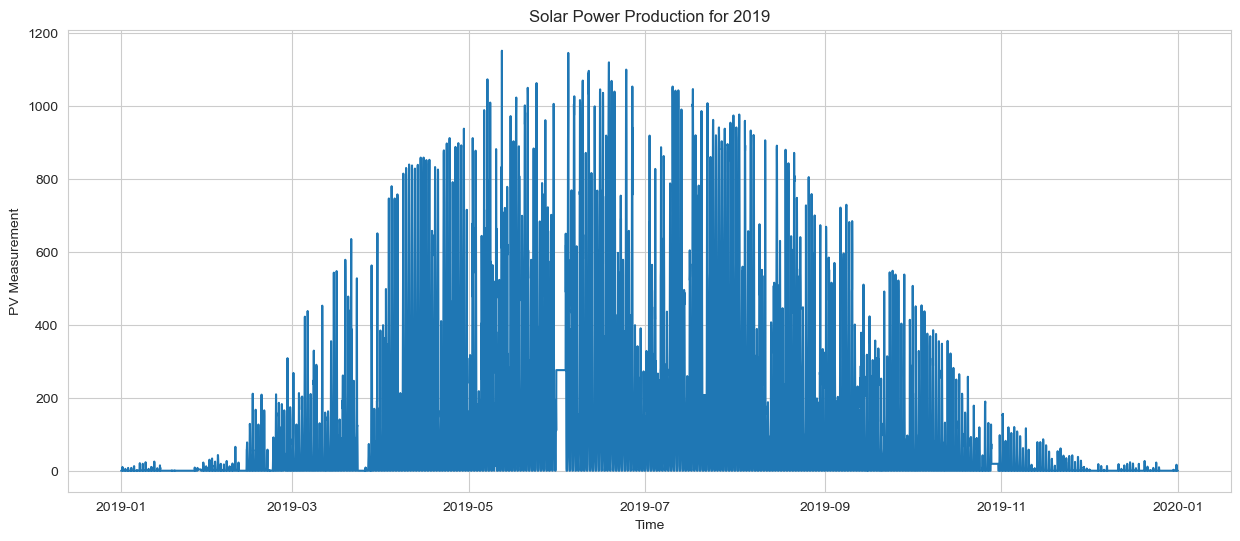

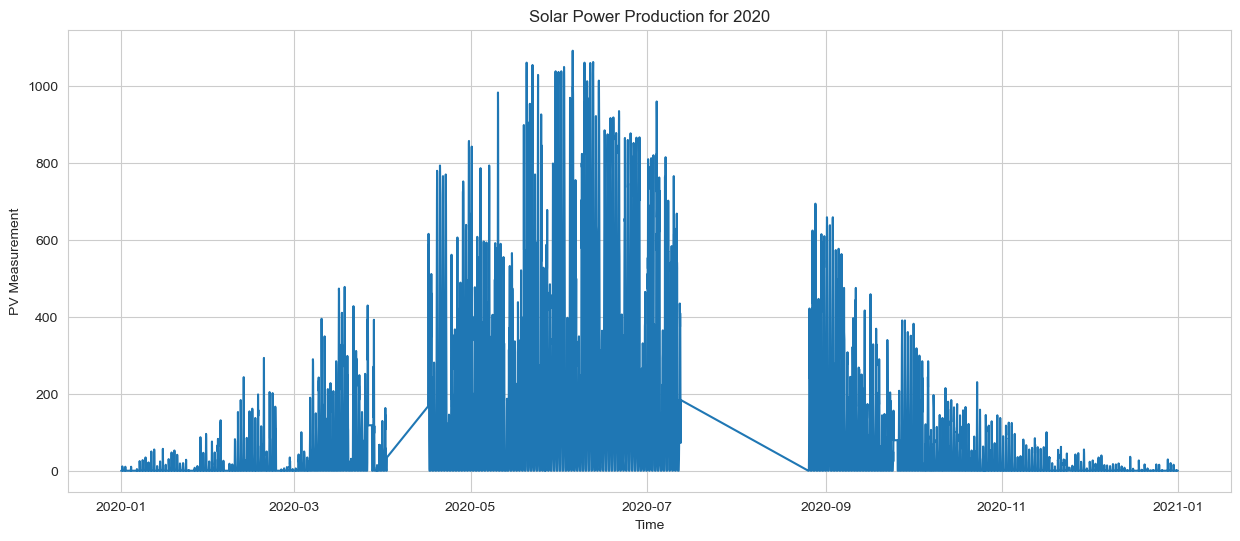

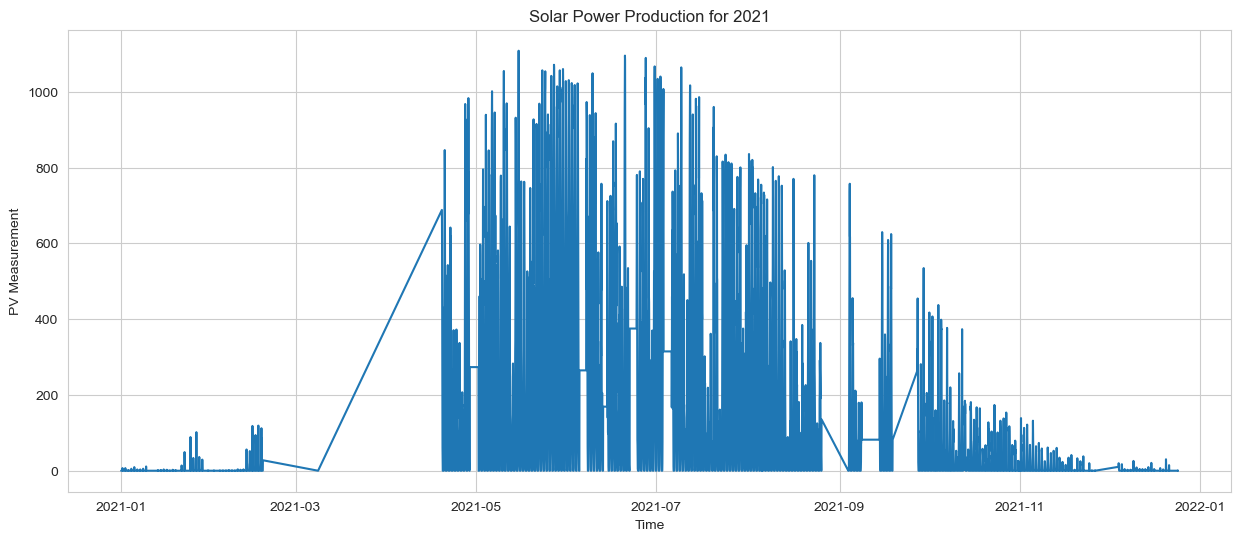

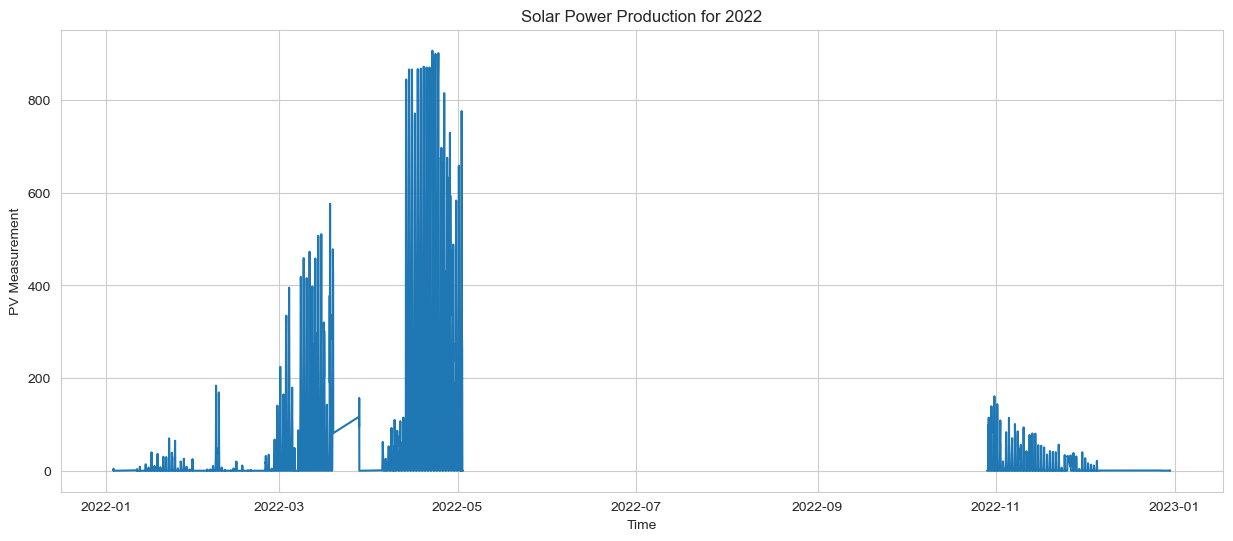

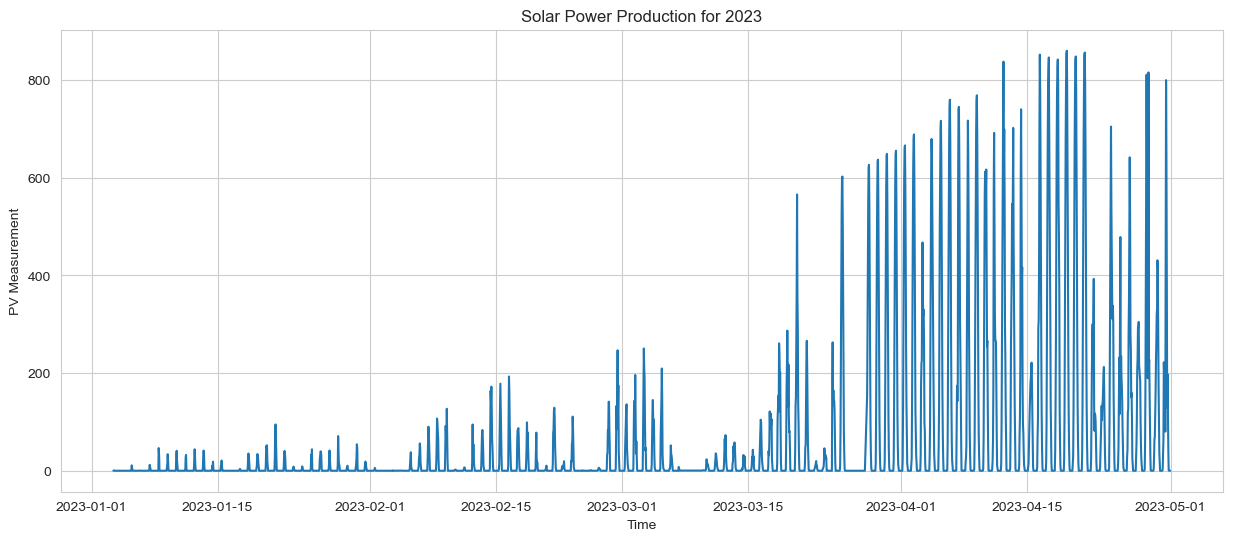

In [160]:
solar_prod_plot(filtered_y_train_b, 1)

In [136]:
def get_time_interval(df, start_time = '2020-08-01 00:00:00', end_time = '2021-01-01 00:00:00'):
    # Filter rows based on the time period
    filtered_df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
    return filtered_df

## Analysis of Decision Variables - Weather featueres
1. Look at each feature isolated (missing and supsicious values) 
2. Look at features vs solar power production (how can we best capture the relationships in our model?)

In [176]:
def plot_feature(feature_name,seaborn_style = True):
    if seaborn_style:
        sns.set_style("whitegrid")
    else:
        seaborn.reset_defaults()
    fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
    X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
    X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
    X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

    X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
    X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
    X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

    X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
    X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
    X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

In [ ]:
feats = list(X_train_observed_a.columns)
plot_feature(feats[2])

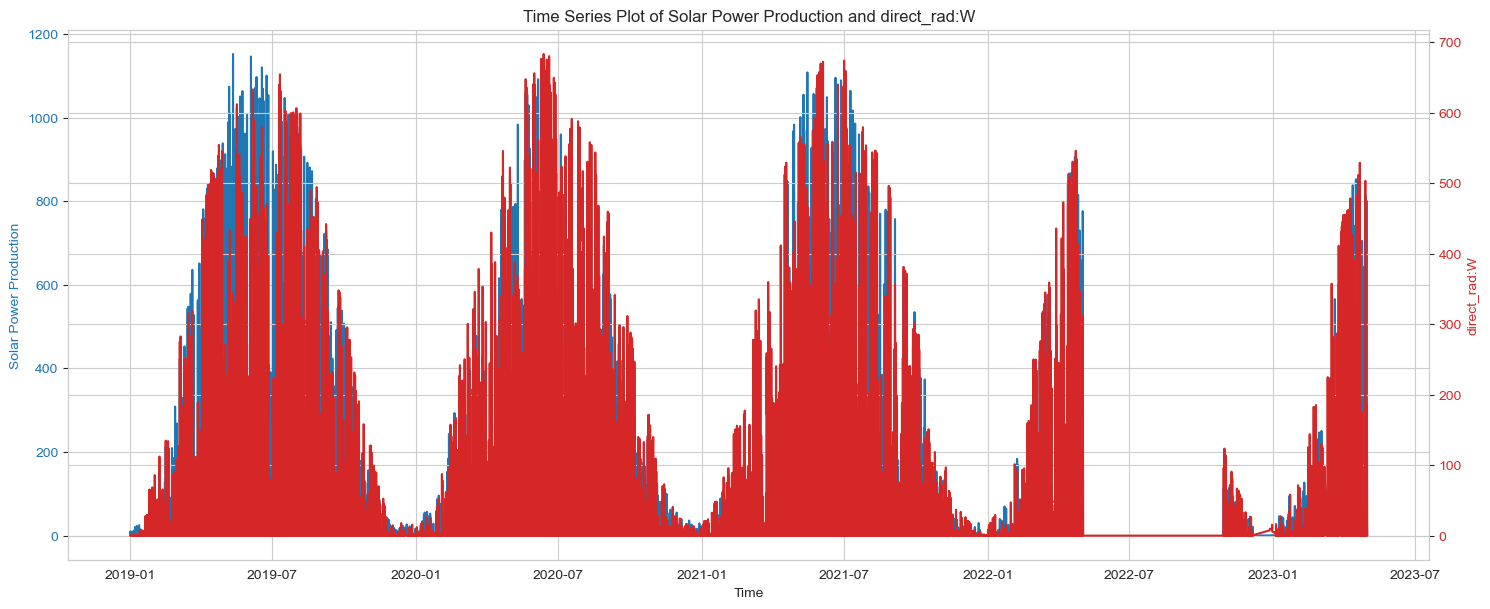

In [17]:

#Here we are plotting on the modified dataset
def time_series_plot(feature):
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Solar Power Production', color='tab:blue')
    ax1.plot(y_train_b['time'], y_train_b['pv_measurement'], color='tab:blue', label='Solar Power Production')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  
    ax2.set_ylabel(feature, color='tab:red')  
    ax2.plot(X_train_b.index, X_train_b[feature], color='tab:red', label=feature)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title(f'Time Series Plot of Solar Power Production and {feature}')
    plt.show()

time_series_plot('direct_rad:W')

# Feature Engineering

In [31]:
#Create time-based features for hour,day, month
def add_time_feat(X):
    X_frame = X.copy()
    X_frame['year'] = X_frame.index.year
    X_frame['month'] = X_frame.index.month
    X_frame['day'] = X_frame.index.day
    X_frame['weekday'] = X_frame.index.weekday
    X_frame['hour'] = X_frame.index.hour
    return X_frame

In [32]:

X_train_a = add_time_feat(X_train_a)
X_test_a = add_time_feat(X_test_a)

X_train_b = add_time_feat(X_train_b)
X_test_b = add_time_feat(X_test_b)

X_train_c = add_time_feat(X_train_c)
X_test_c = add_time_feat(X_test_c)

# Build H2O Model 

In [41]:
from h2o.automl import H2OAutoML

def build_model(X_train,y_train,location,model_name):
    merged_data = X_train.copy()
    merged_data['pv_measurement'] = y_train['pv_measurement'].values
    
    y = 'pv_measurement'
    x = list(X_train_b.columns)
    train = h2o.H2OFrame(merged_data)
    
    aml = H2OAutoML(
        max_models = 20,
        max_runtime_secs = 120,
        #exclude_algos =['DeepLearning'],
        seed = 1,
        # stopping_metric ='logloss',
        sort_metric ='mae',
        balance_classes = False,
        project_name ='Project1'
    )

    aml.train(x=x, y=y, training_frame=train)
    
    lb = aml.leaderboard
    leader = aml.leader
    print(lb.head(rows=lb.nrows))
    
    h2o.save_model(leader, path=f'Saved_models/{location.upper()}',model_id = model_name)

    return lb,leader

def predict(model, X_test):
    
    test = pd.read_csv('test.csv')
    pred_time_stamps = test['time'].unique()
    X_test = X_test[X_test.index.isin(pred_time_stamps)]
    preds = model.predict(h2o.H2OFrame(X_test))
    
    return preds


In [37]:
lb_a,model_a = build_model(X_train_a,y_train_a,'A')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
17:03:52.863: AutoML: XGBoost is not available; skipping it.
17:03:52.884: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█
17:03:54.836: _train param, Dropping bad and constant columns: [snow_drift:idx]

█████████
17:04:12.741: _train param, Dropping bad and constant columns: [snow_drift:idx]

█████████████████████████
17:04:59.186: _train param, Dropping bad and constant columns: [snow_drift:idx]

███████
17:05:14.587: _train param, Dropping bad and constant columns: [snow_drift:idx]

████████
17:05:29.173: _train param, Dropping bad and constant columns: [snow_drift:idx]

█████████
17:05:45.359: _train param, Dropping bad and constant columns: [snow_drift:idx]
17:05:45.436: XRT_1_AutoML_1_20231020_170352 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError
17:05:45.437: _train param, Dropping bad and constant columns: [

In [38]:
lb_b,model_b = build_model(X_train_b,y_train_b,'B')
lb_c,model_c = build_model(X_train_c,y_train_c,'C')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
17:03:52.863: AutoML: XGBoost is not available; skipping it.
17:03:52.884: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]
17:03:54.836: _train param, Dropping bad and constant columns: [snow_drift:idx]
17:04:12.741: _train param, Dropping bad and constant columns: [snow_drift:idx]
17:04:59.186: _train param, Dropping bad and constant columns: [snow_drift:idx]
17:05:14.587: _train param, Dropping bad and constant columns: [snow_drift:idx]
17:05:29.173: _train param, Dropping bad and constant columns: [snow_drift:idx]
17:05:45.359: _train param, Dropping bad and constant columns: [snow_drift:idx]
17:05:45.436: XRT_1_AutoML_1_20231020_170352 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError
17:05:45.437: _train param, Dropping bad and constant columns: [snow_drift:idx]
17:06:54.592: New models will be added to existing lead

In [43]:
#Use model to make predictions on test_data
pred_a = predict(model_a,X_test_a)
pred_b = predict(model_b,X_test_b)
pred_c = predict(model_c, X_test_b)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [86]:
def create_submission(preds_a,preds_b,preds_c,sub_name):
    submission = pd.read_csv('sample_submission.csv')
    predictions = pred_a.rbind(pred_b).rbind(pred_c)
    submission['prediction'] = predictions['predict'].as_data_frame()["predict"].values
    submission.to_csv(f'Submissions/{sub_name}.csv', index=False)
    return submission
    

In [81]:
create submission
first_sub = create_submission(pred_a,pred_b,pred_c,'first_sub')
first_sub

,id,prediction
0,0,0.726615
1,1,0.351885
2,2,0.475944
3,3,69.431245
4,4,542.798441
...,...,...
2155,2155,56.272697
2156,2156,25.471719
2157,2157,21.560861
2158,2158,9.309314


### Analysis of models

In [89]:
model_a

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20231020_170352


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    166                166                         391691                 10           10           10            49            523           183.036

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 16220.449508479584
RMSE: 127.3595285343016
MAE: 60.86791041577922
RMSLE: NaN
Mean Residual Deviance: 16220.449508479584

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 137655.77473676452
RMSE: 371.01991150983326
MAE: 165.53202926357403
RMSLE: NaN
Mean Residual Deviance: 137655.77473676452

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     165.532   2.14516     163.985       164.19        168.934       166.395       164.155
mean_residual_deviance  137656    5493.68     140686        133347        145147        137513        131586
mse                     137656    5493.68     140686        133347        145147        137513        131586
r2                      0.898725  0.00411003  0.897697      0.902036      0.892302      0.899102      0.902487
residual_deviance       137656    5493.68     140686        133347        145147        137513        131586
rmse                    370.961   7.38954     375.081       365.167       380.981       370.828       362.748
rmsle                   nan       0           nan           nan           nan           nan           nan

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------
     2023-10-20 17:05:42  13.008 sec  0.0                1165.8853178627105  829.9770693708241   1359288.5744078336
     2023-10-20 17:05:42  13.131 sec  5.0                753.6087201648666   522.009352139995    567926.1031085281
     2023-10-20 17:05:42  13.268 sec  10.0               524.7801532002175   350.4577272430305   275394.2091928437
     2023-10-20 17:05:42  13.390 sec  15.0               402.16810421961543  252.45533687952275  161739.18405159947
     2023-10-20 17:05:42  13.513 sec  20.0               338.44430692935737  195.7039043469357   114544.54889289307
     2023-10-20 17:05:42  13.628 sec  25.0               301.3047324478501   161.12274412813295  90784.54179547052
     2023-10-20 17:05:42  13.762 sec  30.0               276.59805572647116  139.04370768084212  76506.48443166404
     2023-10-20 17:05:43  13.851 sec  35.0               261.1583506675519   125.67845388725914  68203.68412339599
     2023-10-20 17:05:43  13.945 sec  40.0               249.63587236320342  116.87958551278226  62318.06877053759
     2023-10-20 17:05:43  14.034 sec  45.0               238.83895870980547  109.92823359034567  57044.04819758416
---  ---                  ---         ---                ---                 ---                 ---
     2023-10-20 17:05:44  15.472 sec  125.0              152.55127053414395  71.76387583045245   23271.890141581578
     2023-10-20 17:05:44  15.569 sec  130.0              148.750357328589    70.1357509120968    22126.66880538291
     2023-10-20 17:05:44  15.639 sec  135.0              145.53857594852207  68.75111752570658   21181.477089123724
     2023-10-20 17:05:44  15.718 sec  140.0              142.59909840892388  67.47070996381481   20334.502867037958
     2023-10-20 

In [103]:
# 2. Feature Importance
def feat_importance(model, n_feats):
    feature_importance = model.varimp(use_pandas=True)
    n_top_feats = feature_importance.iloc[:n_feats,:]
    return n_top_feats

In [105]:
top_12_feats_a = feat_importance(model_a,12)
top_12_feats_a

,variable,relative_importance,scaled_importance,percentage
0,direct_rad:W,1.301484e+11,1.000000,0.571620
1,direct_rad_1h:J,3.686239e+10,0.283234,0.161902
2,diffuse_rad:W,1.102335e+10,0.084698,0.048415
3,clear_sky_rad:W,8.103208e+09,0.062261,0.035590
4,sun_elevation:d,4.915054e+09,0.037765,0.021587
5,clear_sky_energy_1h:J,3.990662e+09,0.030662,0.017527
6,sun_azimuth:d,2.998016e+09,0.023035,0.013167
7,hour,2.216867e+09,0.017033,0.009737
8,wind_speed_u_10m:ms,1.753712e+09,0.013475,0.007702
9,day,1.579523e+09,0.012136,0.006937


In [106]:
feat_importance(model_b,12)

,variable,relative_importance,scaled_importance,percentage
0,sun_elevation:d,2.347879e+09,1.000000,0.394329
1,clear_sky_energy_1h:J,8.244848e+08,0.351162,0.138473
2,clear_sky_rad:W,7.471388e+08,0.318219,0.125483
3,direct_rad:W,5.201490e+08,0.221540,0.087360
4,direct_rad_1h:J,2.032366e+08,0.086562,0.034134
5,year,1.387539e+08,0.059098,0.023304
6,month,1.262000e+08,0.053751,0.021195
7,diffuse_rad:W,1.137546e+08,0.048450,0.019105
8,day,7.502422e+07,0.031954,0.012600
9,effective_cloud_cover:p,6.706543e+07,0.028564,0.011264


In [107]:
feat_importance(model_c,12)

,variable,relative_importance,scaled_importance,percentage
0,sun_elevation:d,2.347879e+09,1.000000,0.394329
1,clear_sky_energy_1h:J,8.244848e+08,0.351162,0.138473
2,clear_sky_rad:W,7.471388e+08,0.318219,0.125483
3,direct_rad:W,5.201490e+08,0.221540,0.087360
4,direct_rad_1h:J,2.032366e+08,0.086562,0.034134
5,year,1.387539e+08,0.059098,0.023304
6,month,1.262000e+08,0.053751,0.021195
7,diffuse_rad:W,1.137546e+08,0.048450,0.019105
8,day,7.502422e+07,0.031954,0.012600
9,effective_cloud_cover:p,6.706543e+07,0.028564,0.011264


In [87]:
"""pred_df = X_test_b.copy()
pred_df["prediction"] = preds.as_data_frame()["predict"].values


plt.figure(figsize=(10, 6))
plt.plot(pred_df.index.values, pred_df['prediction'], '-o', label='Predictions', color='blue')
plt.title('Predicted Solar Energy Production')
plt.xlabel('Timestamp')
plt.ylabel('Solar Energy Production pv')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()"""

'pred_df = X_test_b.copy()\npred_df["prediction"] = preds.as_data_frame()["predict"].values\n\n\nplt.figure(figsize=(10, 6))\nplt.plot(pred_df.index.values, pred_df[\'prediction\'], \'-o\', label=\'Predictions\', color=\'blue\')\nplt.title(\'Predicted Solar Energy Production\')\nplt.xlabel(\'Timestamp\')\nplt.ylabel(\'Solar Energy Production pv\')\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.xticks(rotation=45)\nplt.show()'

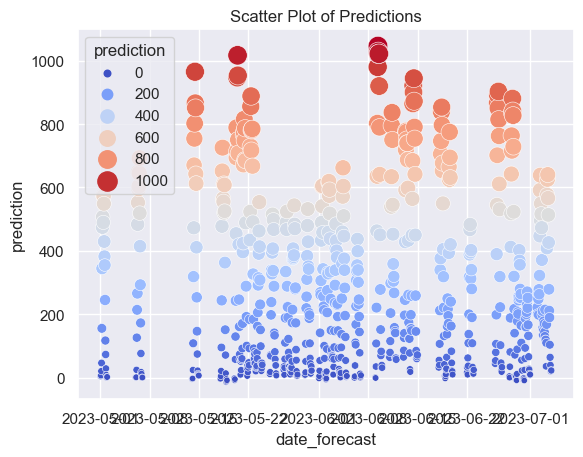

In [93]:
"""import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")
sns.scatterplot(x='date_forecast', y='prediction', data=pred_df.reset_index(), hue='prediction', palette="coolwarm", size='prediction', sizes=(20, 200))
plt.title("Scatter Plot of Predictions");"""

In [88]:
"""sns.histplot(pred_df['prediction'], bins=10, kde=True, color='dodgerblue')
plt.title("Distribution of Predictions");"""

'sns.histplot(pred_df[\'prediction\'], bins=10, kde=True, color=\'dodgerblue\')\nplt.title("Distribution of Predictions");'

In [11]:
highly_relevant = [
    'clear_sky_rad:W', 
    'direct_rad:W', 
    'direct_rad_1h:J', 
    'diffuse_rad:W', 
    'diffuse_rad_1h:J',
    'effective_cloud_cover:p', 
    'is_day:idx', 
    'is_in_shadow:idx', 
    'sun_elevation:d', 
    'sun_azimuth:d',
    'total_cloud_cover:p',
    'clear_sky_energy_1h:J'
]

moderately_relevant = [
    'fresh_snow_6h:cm'
    'fresh_snow_12h:cm',
    'fresh_snow_24h:cm',
    'ceiling_height_agl:m', 
    'cloud_base_agl:m', 
    'snow_depth:cm', 
    'fresh_snow_1h:cm', 
    'fresh_snow_3h:cm',
    'wind_speed_10m:ms', 
    'wind_speed_u_10m:ms', 
    'wind_speed_v_10m:ms', 
    'visibility:m'
]

less_relevant = [
    'absolute_humidity_2m:gm3', 
    'dew_point_2m:K', 
    'msl_pressure:hPa', 
    'precip_5min:mm', 
    'rain_water:kgm2',
    'sfc_pressure:hPa', 
    'snow_density:kgm3', 
    'snow_melt_10min:mm',
    'air_density_2m:kgm3'
]

not_included = ['elevation:m',
 'pressure_50m:hPa',
 'super_cooled_liquid_water:kgm2',
 'precip_type_5min:idx',
 'dew_or_rime:idx',
 'snow_water:kgm2',
 'prob_rime:p',
 'snow_drift:idx',
 't_1000hPa:K',
 'wind_speed_w_1000hPa:ms',
 'relative_humidity_1000hPa:p',
 'date_calc',
 'pressure_100m:hPa']


#not_included = list(set(X_train_b.columns)-set(highly_relevant) - set(moderately_relevant)-set(less_relevant))


#len(highly_relevant)+len(moderately_relevant)+len(less_relevant) + len(not_included)